In [166]:
import numpy as np
import scipy.integrate as integrate
import matplotlib as mpl
mpl.use('pgf')
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
from cycler import cycler
import scipy.interpolate
import matplotlib.ticker as mticker
import time
from scipy.optimize import curve_fit
import math
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [167]:
myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

In [168]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [169]:
def RescalingCenters(DataSet, Nbins, Bins_limit=None):

    if Bins_limit==None:
        bins_max=DataSet[-1][0]
        bins_min=DataSet[0][0]
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]
        
    x_data=DataSet[:,0]
    bins_edges=np.logspace(np.log10(bins_min), np.log10(bins_max), Nbins+1)
    bins_centers = np.array([0.5 * (bins_edges[i] + bins_edges[i+1]) for i in range(Nbins)])
    y_data=DataSet[:,1]

    y_stackable = np.zeros(Nbins)

    for j in range(Nbins):
        for i in range(len(x_data)):
            if (x_data[i]<bins_edges[j+1])and(x_data[i]>bins_edges[j]):
                x_data[i]=bins_centers[j]
                y_stackable[j]=round(y_data[i])
            else:
                pass

        
    return bins_edges, bins_centers,  y_stackable

In [170]:
def DataStack(DataSets, Nbins, Bins_limit=None):

    if Bins_limit==None:
        a=np.empty(len(DataSets), dtype=object)
        for i in range(len(DataSets)):
            a[i] = DataSets[i][:,0]
        a=np.concatenate(a)
        
        bins_max=max(a)

        bins_min=min(a)

        bins_limit=(bins_min, bins_max)
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]


    y_stacked = np.zeros(Nbins)
    for i in range(len(DataSets)):

        bins_edges, bins_center, y_stackable = RescalingCenters(DataSets[i], Nbins, Bins_limit=(bins_min, bins_max))
        y_stacked += y_stackable
    

    return bins_edges, bins_center, y_stacked

In [171]:
def LogGaussian(x, s, mu):
    return (1 / (s*np.sqrt(2 * np.pi))) * np.exp(-(np.log10(x) - mu)**2 / (2 * s**2))
    

In [172]:
def LogGaussianfit(x, y, s_interval=None, mu_interval=None):
    x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 100) 
    
    if s_interval==None:
        s_min=None
        s_max=None
    else: 
        s_min, s_max=s_interval
    if mu_interval==None:
        mu_min=None
        mu_max=None
    else: 
        mu_min, mu_max=mu_interval

    popt, pcov = curve_fit(LogGaussian, x, y,  bounds=([s_min, mu_min], [s_max, mu_max]))
    y_fit = LogGaussian(x_fit, *popt)
    return x_fit, y_fit, pcov

In [173]:
#Hirano 2014
pathfit_Hirano2014 = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2014/'
name_Hirano2014 = ['Total', 'Bins']
Hirano2014 = np.empty(len(name_Hirano2014), dtype=object)
Nbins_Hirano2014 = 26
for i in range(len(name_Hirano2014)):
    Hirano2014[i] = np.genfromtxt(pathfit_Hirano2014 + name_Hirano2014[i] +'.csv', delimiter=';')

Bins_Hirano2014_min = Hirano2014[-1][0][0]
Bins_Hirano2014_max = Hirano2014[-1][1][0]
Bins_limit_Hirano2014=(9.9, 1700)

Hirano2014_edges, Hirano2014_centers, Hirano2014_Y = DataStack(Hirano2014, Nbins_Hirano2014)

In [174]:
Hirano2014_centers_fitted, Hirano2014_Y_fitted, Err_H2014 = LogGaussianfit(Hirano2014_centers, Hirano2014_Y, (0.3,1), (1,3))

array([   7.45205192,    9.20939506,   11.38115493,   14.06505928,
         17.38188205,   21.48087808,   26.5464995 ,   32.80669594,
         40.54317212,   50.10406439,   61.91960661,   76.5214904 ,
         94.56679094,  116.86753488,  144.42724104,  178.48607807,
        220.57667124,  272.59306956,  336.87597676,  416.31808137,
        514.49422587,  635.82227219,  785.76190264,  971.06030198,
       1200.05577633, 1483.05297144])

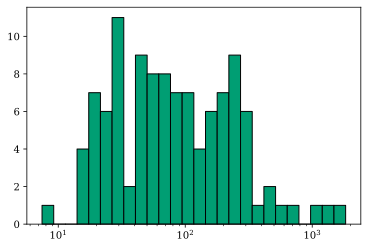

In [175]:
plt.bar(Hirano2014_edges[:-1], Hirano2014_Y, width=np.diff(Hirano2014_edges), ec="k", align="edge")
# plt.plot(Hirano2014_centers_fitted, Hirano2014_Y_fitted)

plt.xscale('log')
Hirano2014_edges[:-1]

In [176]:
#Susa2014

pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_susa = ['z<10', '10<z<14', '14<z']
Susa = np.empty(len(name_susa), dtype=object)
for i in range(len(name_susa)):
    Susa[i] = np.genfromtxt(pathfit_susa + name_susa[i] +'.csv', delimiter=';')

Bins_limit_Susa=[[0.47109741431987984, 297.00189937790844]]
Nbins_Susa = 20


In [177]:
Susa_Y = np.empty(len(Susa), dtype=object)
Susa_edges = np.empty(len(Susa), dtype=object)
Susa_centers = np.empty(len(Susa), dtype=object)
Susa_centers_fits = np.empty(len(Susa), dtype=object)
Susa_Y_fits = np.empty(len(Susa), dtype=object)
for i in range(len(Susa)):
    Susa_edges[i], Susa_centers[i], Susa_Y[i] =RescalingCenters(Susa[i], Nbins_Susa, Bins_limit=[0.47109741431987984, 297.00189937790844])
    Susa_centers_fits[i], Susa_Y_fits[i], Err_H2014 = LogGaussianfit(Susa_centers[i], Susa_Y[i], (0.7,1), (1,2.5))

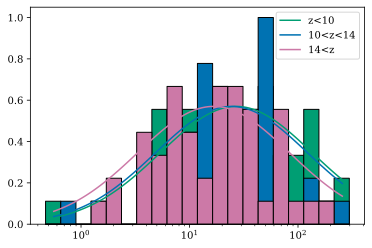

In [178]:
for i in range(3):
    plt.bar(Susa_edges[i][:-1], Susa_Y[i]/9, width=np.diff(Susa_edges[i]), ec="k", align="edge")    
    plt.plot(Susa_centers_fits[i], Susa_Y_fits[i], label=f'{name_susa[i]}')
plt.xscale('log')
plt.legend()

In [179]:
#Stacy 2013
def Stacy2013(M, M_min, M_max):
    IMF = M**(-0.17)
    N = integrate.quad(lambda M: IMF, M_min, M_max, epsrel=1e-2)[0]
    return IMF/N

In [180]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)


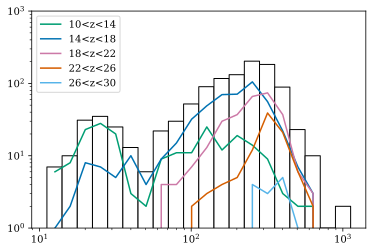

In [181]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

In [182]:
def Stacy2013(M, M_min, M_max):
    IMF = M**(-0.17)
    N = integrate.quad(lambda M: IMF, M_min, M_max, epsrel=1e-2)[0]
    return IMF/N


No handles with labels found to put in legend.


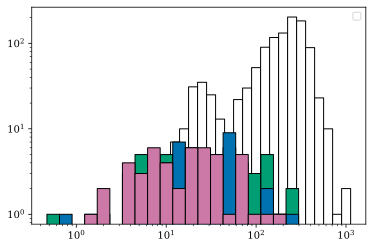

In [183]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(len(Susa_Y)):
    plt.bar(Susa_edges[i][:-1], Susa_Y[i], width=np.diff(Susa_edges[i]), ec="k", align="edge")   
plt.yscale('log')
plt.xscale('log')
plt.legend()

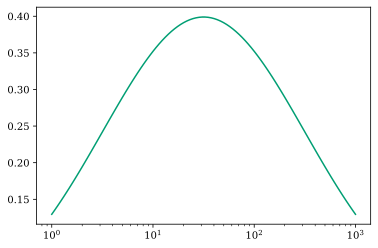

In [184]:
x=np.logspace(0,3, 100)
y=LogGaussian(x, 1, 1.5)
plt.plot(x, y)
plt.xscale('log')

In [185]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)
print(x_bins, N_per_halos)


[1 2 3 4 5 6] [21. 11. 14.  8.  1.  4.]


In [186]:
def PowerLaw(x, A, a):
    return A*np.exp(-x*a)

In [187]:
x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
N_tot = np.sum(N_per_halos)

Text(0, 0.5, 'Number of halo')

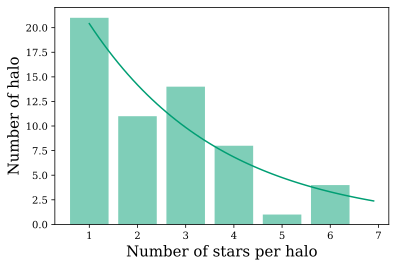

In [188]:
plt.bar(x_bins, N_per_halos, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[0])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')

In [189]:
N_per_halos_z30 = np.array([0.8, 0.2, 0., 0., 0., 0.])
popt30, pcov30 = curve_fit(PowerLaw, x_bins, N_per_halos_z30,  bounds=([18, 0], [30, 10]))
y_fit_NH_30 = PowerLaw(x_fit_NH, *popt30)

A30, a30 = popt30

In [190]:
def PowerLaw_norm(x, A, a):
    N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
    return A*np.exp(-x*a)


In [191]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
N_per_halos_z10 = N_per_halos/N_NH

popt10, pcov10 = curve_fit(PowerLaw_norm, x_bins, N_per_halos_z10,  bounds=([0, 0], [30, 10]))
y_fit_NH_10 = PowerLaw(x_fit_NH, *popt10)

A10, a10 = popt10

Text(0, 0.5, 'Number of halo')

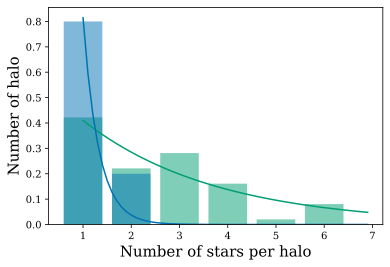

In [192]:

y_fit_norm = y_fit_NH/N_NH

plt.plot(x_fit_NH, y_fit_NH_10, color=myColors[0])
plt.bar(x_bins, N_per_halos_z10, alpha = 0.5)
plt.bar(x_bins, N_per_halos_z30, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH_30, color=myColors[1])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')


In [199]:
print(A10, a10, A30, a30)


def Az(z):
    A_int = scipy.interpolate.interp1d((10, 30),(A10, A30))
    return float(A_int(z))

def az(z):
    a_int = scipy.interpolate.interp1d((10, 30),(a10, a30))
    return float(a_int(z))



def PowerLaw_Z(n_h, z):
    def PowerLaw_z(n_h, z):
        A = Az(z)
        a = az(z)
        N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
        return A*np.exp(-n_h*a)/N_NH
    v= np.vectorize(PowerLaw_z)
    return v(n_h, z)



0.5901484723023565 0.3639234868729161 18.000000000000185 3.0952375475519376


In [200]:
PowerLaw_Z(2, 11)

array(0.31926211)

In [201]:
n_h = np.linspace(1, 7, 100)
z = np.linspace(10, 30, 100)

x, y = np.meshgrid(n_h, z)

# pl = np.empty(len(n_h), dtype=object)
# for i in range(len(pl)):
#     plz = np.empty(len(z), dtype=object)
#     for ii in range(len(z)):
#         plz[ii] = PowerLaw_Z(n_h[i], z[ii])
#     pl[i]=plz
pl = np.array(PowerLaw_Z(x, y))

In [202]:
pl.shape


(100, 100)

Text(0, 0.5, 'Power Law')

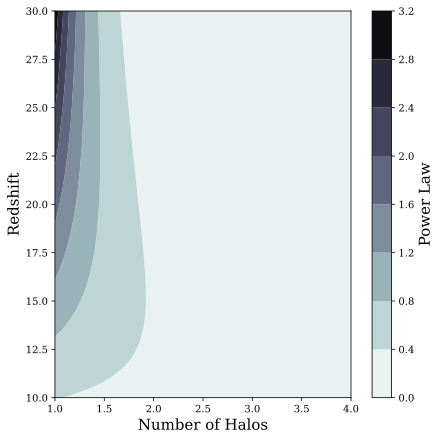

In [217]:
fig1, ax2 = plt.subplots(constrained_layout=True, figsize=(6 , 6))

origin = 'lower'

CS = ax2.contourf(n_h, z, pl, cmap=plt.cm.bone_r, origin=origin)
ax2.set_xlabel('Number of Halos')
ax2.set_ylabel('Redshift')
ax2.set_xlim(1, 4)

# CS2 = ax2.contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Power Law')

# cbar.add_lines(CS2)

We want to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we needed the IMF of the halos, the distribution of stars in the halos and their IMFwe have now everything we wanted to perform this.

/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/PressSchechter.ipynb:235: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  "        \n",
/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/PressSchechter.ipynb:179: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  "    \"\"\"\n",


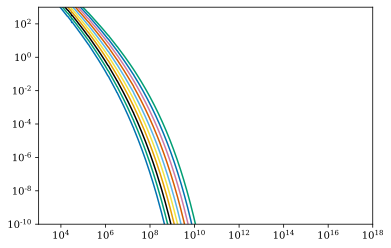

In [ ]:
#P.D.F. of the halo IMF 
from ipynb.fs.full.PressSchechter import HaloMassFunction 

HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

H_IMF = HMF.IMF


In [ ]:
#Possible halo mass range 10^3-10^7
z = 30
HM_interval=(10**3, 10**7)
H_IMF_Norm = integrate.quad(H_IMF, HM_interval[0], HM_interval[1], args=(z), epsrel=1e-4, limit=1000)[0]

def H_PDF_M(M):
    return H_IMF(M, z)/H_IMF_Norm

<ipython-input-33-2a40e189312f>:4: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  H_IMF_Norm = integrate.quad(H_IMF, 10**3, 10**7, args=(z), epsrel=1e-7, limit=1000)[0]


In [ ]:
m = np.logspace(3, 7, 1000)
pdf = H_PDF_M(m)
PDF_spl = scipy.interpolate.splrep(m, pdf, k=3)
gen = np.random.default_rng()

def PDF(m):
    return scipy.interpolate.splev(m, PDF_spl)

In [ ]:
def StarsGenerator(ninput):

    fmax=PDF(HM_interval[0])+0.02*PDF(HM_interval[0])
    x_output=np.array([])
    
    ii=0
    t=[]
    while ii<ninput:
        # t0      =time.time()
        # t.append(time.time()-t0)
        x = gen.uniform(*HM_interval, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= PDF(x, PDF_spl))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        # if(ii>=100):
        #     t_tot =np.mean(t)*ninput
        #     print(" Time for 1 loop is approx:", np.mean(t)
        #         , "\n Comp is finished in ", t_tot, "s"
        #         , " = " , t_tot/60 , "min" )
    return x_output



In [ ]:
n_halos=10000

Halos = StarsGenerator(n_halos)

0
3
3
4
5
6
10
14
17
21
21
23
26
29
30
30
31
33
38
41
43
45
48
53
56
58
62
63
64
68
70
74
75
75
75
77
79
82
83
85
86
86
87
88
88
92
92
92
96
100
100
100
102
103
104
106
108
110
110
110
113
116
116
118
121
121
122
125
127
128
132
134
136
136
139
140
142
144
147
148
148
151
151
153
156
159
161
163
164
164
165
169
171
175
177
177
180
181
185
186
187
189
190
192
194
194
198
198
199
199
201
205
205
208
209
209
210
212
213
215
219
219
220
222
222
222
224
226
230
230
232
234
235
238
238
241
241
241
243
243
244
246
247
247
251
251
251
251
251
254
256
256
256
257
259
260
260
261
263
267
269
271
274
277
278
278
281
284
284
286
287
288
290
291
291
294
300
300
302
307
308
311
312
313
316
318
320
320
324
325
327
328
333
334
334
336
338
338
339
340
342
343
344
348
348
350
350
352
352
353
354
356
360
361
361
361
361
362
365
365
368
370
371
373
373
373
375
375
375
377
385
388
388
391
393
395
398
402
405
405
407
409
410
413
415
416
417
417
417
417
420
420
422
422
422
424
425
425
428
429
429
429
431
431

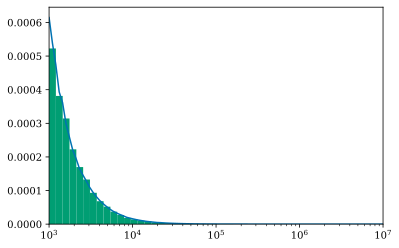

In [ ]:
plt.hist(Halos, density=True, bins=10**np.linspace(3, 7, 50))
M=np.logspace(3, 7, 100)
plt.plot(M, PDF(M))
plt.xlim(10**3, 10**7)
plt.xscale('log')

We have generated a sample of halos between 10^5 to 10^7 Msun followinf the HIMF.
We will now consider different popIII IMF (starting with the Susa 2014)

In [ ]:
def POPIII_PDF(M):
    L= LogGaussian(M, 0.70000001, 1.43117402)
    N=integrate.quad(LogGaussian, 0, 10**3, args=(0.70000001, 1.43117402))[0]
    return L/N

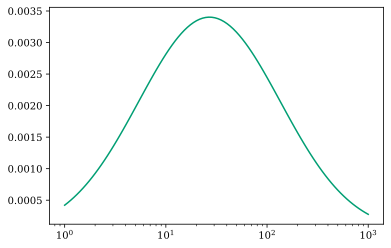

In [ ]:
M=np.logspace(0, 3, 100)
plt.plot(M, POPIII_PDF(M))
plt.xscale('log')